In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t, ttest_ind
import uncertainties as unc
import seaborn as sns
import pandas as pd
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix
import json
# Ensure plots are shown in Jupyter notebook
%matplotlib inline





## Study Population


--- GENDER DISTRIBUTION ---


/var/folders/z4/s381pg0d2x72dlyfsty02y0c0000gn/T/ipykernel_82570/2004145719.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


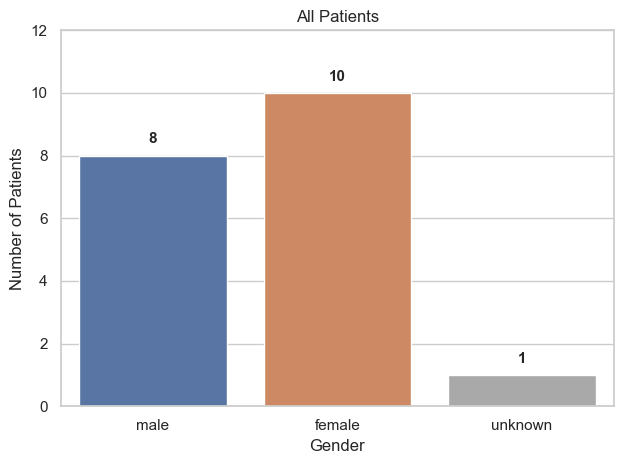

/var/folders/z4/s381pg0d2x72dlyfsty02y0c0000gn/T/ipykernel_82570/2004145719.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


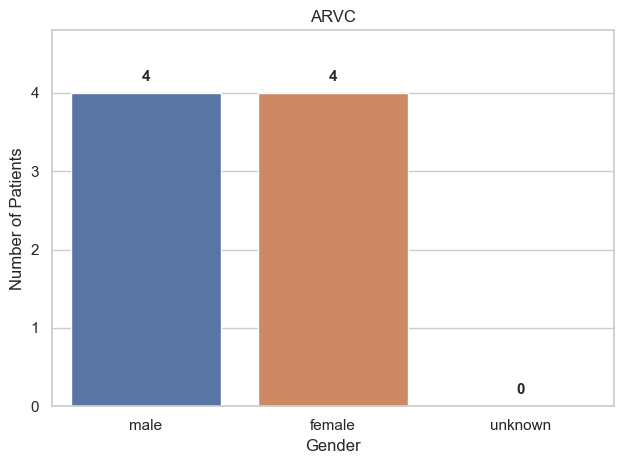

/var/folders/z4/s381pg0d2x72dlyfsty02y0c0000gn/T/ipykernel_82570/2004145719.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


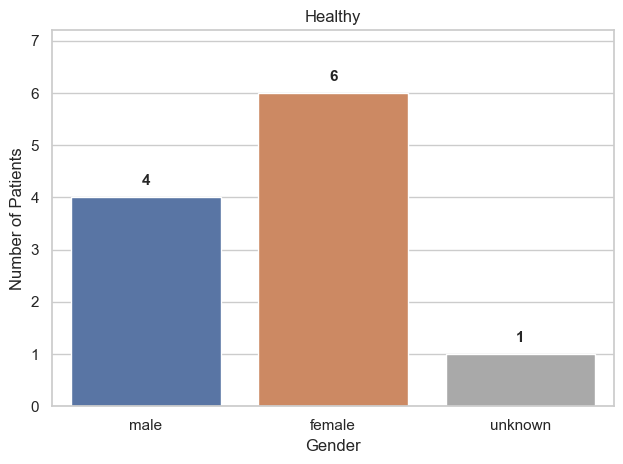


--- AGE & HEIGHT (All Patients) ---
Age Distribution (All): Mean = 35.37, Std = 12.61


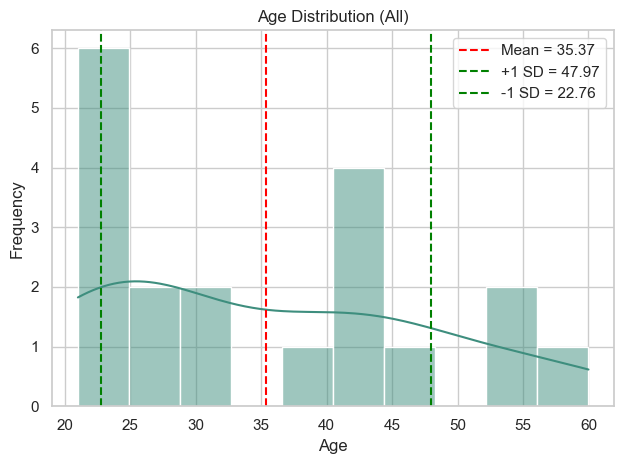

Height Distribution (All): Mean = 1.72, Std = 0.07


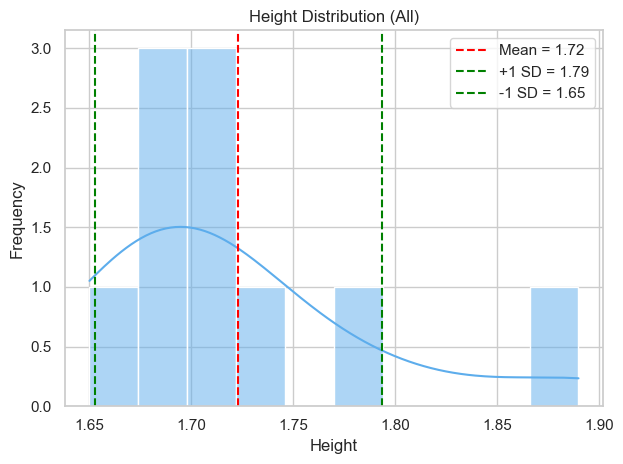


--- AGE & HEIGHT (ARVC Positive) ---
Age Distribution (ARVC): Mean = 41.00, Std = 15.14


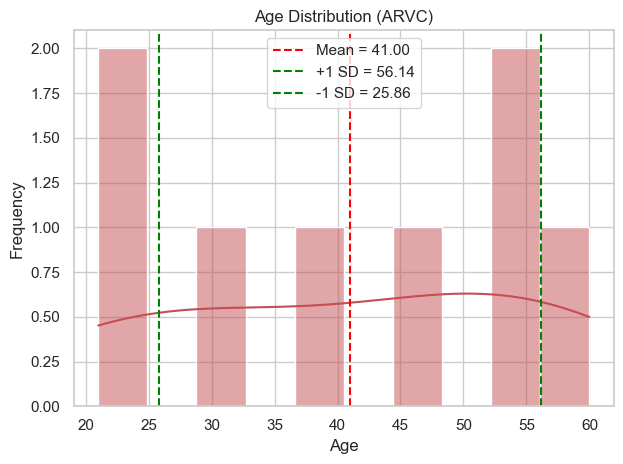

Height Distribution (ARVC): Mean = nan, Std = nan


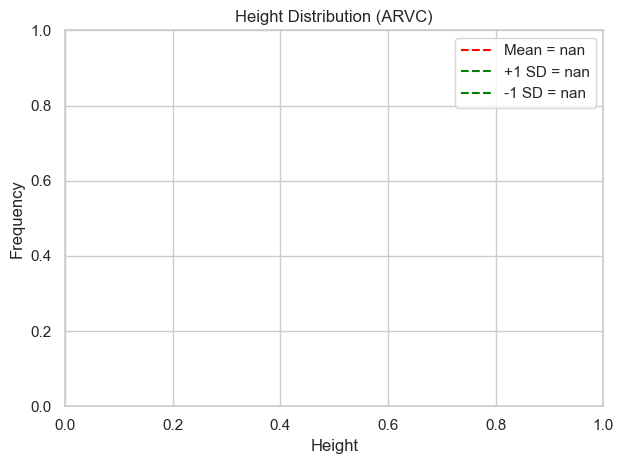


--- AGE & HEIGHT (ARVC Negative) ---
Age Distribution (Healthy): Mean = 31.27, Std = 9.05


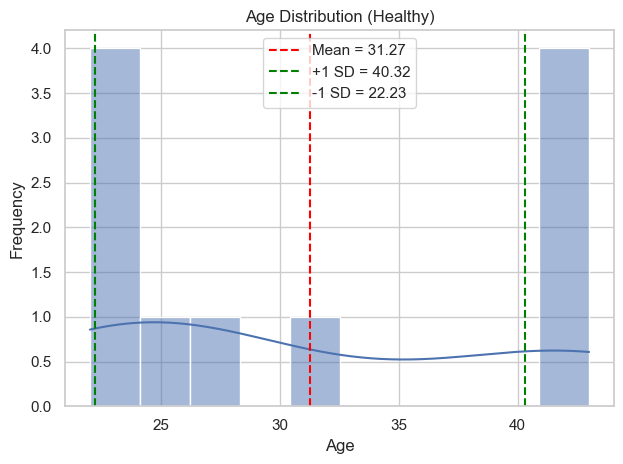

Height Distribution (Healthy): Mean = 1.72, Std = 0.07


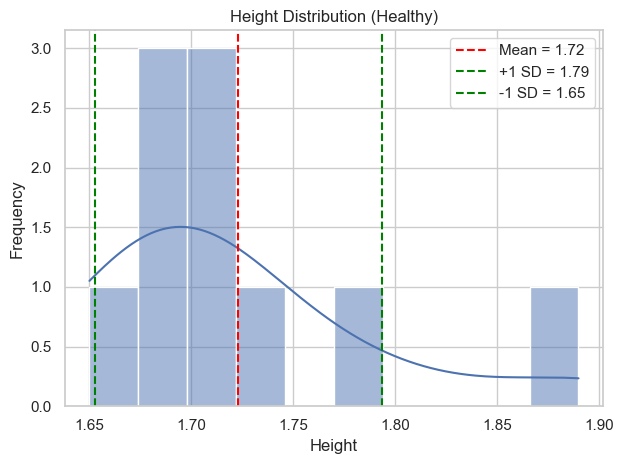

In [5]:

# Load the JSON data
with open("Data/setup.json") as f:
    data = json.load(f)

# Flatten data
records = []
for pid, patient_data in data.items():
    gender = patient_data.get("gender")
    height = patient_data.get("height")
    age = patient_data.get("age")
    
    for run_id, run_info in patient_data["runs"].items():
        records.append({
            "patient": pid,
            "run": run_id,
            "gender": gender if gender else "unknown",
            "height": float(height) if height not in [None, ""] else None,
            "age": int(age) if age not in [None, ""] else None,
            "ARVC": run_info["ARVC"]
        })

df = pd.DataFrame(records)

# Seaborn styling
sns.set(style="whitegrid")

# Define fixed color palette for gender
gender_palette = {
    "male": "#4C72B0",     # Muted blue
    "female": "#DD8452",   # Warm orange
    "unknown": "#A9A9A9"   # Soft gray
}

def plot_gender_distribution(data, title):
    counts = data["gender"].value_counts()
    genders_order = ["male", "female", "unknown"]
    counts = counts.reindex(genders_order).fillna(0)

    ax = sns.barplot(
        x=counts.index,
        y=counts.values,
        palette=[gender_palette.get(g, "#cccccc") for g in counts.index]
    )
    plt.title(title)
    plt.ylabel("Number of Patients")
    plt.xlabel("Gender")

    # Add nicely placed labels
    for i, v in enumerate(counts.values):
        ax.text(i, v + max(counts.values) * 0.03, str(int(v)), 
                ha='center', va='bottom', fontweight='bold', fontsize=11)

    plt.ylim(0, max(counts.values) * 1.20)
    plt.tight_layout()
    plt.show()


# Now call the function without passing different palettes
print("\n--- GENDER DISTRIBUTION ---")
plot_gender_distribution(df, "All Patients")
plot_gender_distribution(df[df["ARVC"] == True], "ARVC")
plot_gender_distribution(df[df["ARVC"] == False], "Healthy")


# ----------- AGE & HEIGHT DISTRIBUTION + STATS -----------
def plot_hist_and_stats(data, column, title, color):
    valid_data = data[column].dropna()
    mean = valid_data.mean()
    std = valid_data.std()
    print(f"{title}: Mean = {mean:.2f}, Std = {std:.2f}")
    
    sns.histplot(valid_data, kde=True, color=color, bins=10)
    plt.axvline(mean, color='red', linestyle='--', label=f'Mean = {mean:.2f}')
    plt.axvline(mean + std, color='green', linestyle='--', label=f'+1 SD = {mean+std:.2f}')
    plt.axvline(mean - std, color='green', linestyle='--', label=f'-1 SD = {mean-std:.2f}')
    plt.title(title)
    plt.xlabel(column.capitalize())
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ALL
print("\n--- AGE & HEIGHT (All Patients) ---")
plot_hist_and_stats(df, "age", "Age Distribution (All)", "#3E8E7E")
plot_hist_and_stats(df, "height", "Height Distribution (All)", "#5DADEC")

# ARVC+
print("\n--- AGE & HEIGHT (ARVC Positive) ---")
plot_hist_and_stats(df[df["ARVC"] == True], "age", "Age Distribution (ARVC)", "#C44E52")
plot_hist_and_stats(df[df["ARVC"] == True], "height", "Height Distribution (ARVC)", "#C44E52")

# ARVC−
print("\n--- AGE & HEIGHT (ARVC Negative) ---")
plot_hist_and_stats(df[df["ARVC"] == False], "age", "Age Distribution (Healthy)", "#4C72B0")
plot_hist_and_stats(df[df["ARVC"] == False], "height", "Height Distribution (Healthy)", "#4C72B0")


In [102]:
# Load the CSV file
csv_df = pd.read_csv("Results/OQ_xy.csv")  # Replace with the actual path

# Load the JSON file with ARVC info
with open("Data/setup.json") as f:  # Replace with the actual path
    json_data = json.load(f)

# Build a dictionary mapping (patient, run) -> ARVC
arvc_map = {}
for pid, pdata in json_data.items():
    for run_id, run_data in pdata["runs"].items():
        arvc_map[(pid, run_id)] = run_data["ARVC"]

# Add ARVC column to CSV data
csv_df["ARVC"] = csv_df.apply(lambda row: arvc_map.get((row["patient"], row["run"]), None), axis=1)

print(csv_df)

# Check missing ARVCs
missing = csv_df["ARVC"].isna().sum()
if missing > 0:
    print(f"Warning: {missing} rows missing ARVC information!")

# Prepare T, QRS, ST data splits
t_cols = ["t_Area", "t_T-Dist", "t_Compact", "t_Angle"]
qrs_cols = ["qrs_Area", "qrs_T-Dist", "qrs_Compact", "qrs_Angle"]
st_cols = ["st_Area", "st_T-Dist", "st_Compact", "st_Angle"]

positive_data_T = csv_df[csv_df["ARVC"] == True][t_cols].dropna(how="all")
negative_data_T = csv_df[csv_df["ARVC"] == False][t_cols].dropna(how="all")

positive_data_QRS = csv_df[csv_df["ARVC"] == True][qrs_cols].dropna(how="all")
negative_data_QRS = csv_df[csv_df["ARVC"] == False][qrs_cols].dropna(how="all")

positive_data_ST = csv_df[csv_df["ARVC"] == True][st_cols].dropna(how="all")
negative_data_ST = csv_df[csv_df["ARVC"] == False][st_cols].dropna(how="all")

   patient  run      t_Area   t_T-Dist  t_Compact     t_Angle    qrs_Area  \
0     P004  S00   14.401647   3.620396   1.046476  139.882143   61.142927   
1     P004  S02    3.718023   5.497802   0.292545  177.290809   59.756542   
2     P005  S01  123.890732  17.581280   1.101579  -75.893587   15.964916   
3     P007  S01   35.677749  10.545391   0.582650  -69.803115  295.091982   
4     P008  S01   12.048302   8.240334   0.204383 -171.600652   24.383049   
5     P009  S01   12.524240   3.899952   0.641962  -74.865628    0.444831   
6     P010  S01   13.270467  15.426044   0.192599  -59.106454  117.858679   
7     P011  S01   11.259253   2.539478   0.228223  150.837725   16.372353   
8     P012  S01   44.877595   9.791820   1.230588  164.576845  237.022245   
9     P013  S01    0.761335   4.683354   0.255839   88.944647    0.129814   
10    P014  S01    3.355881   6.919428   0.397967   71.349149   10.902947   
11    P015  S01    7.853445  13.475672   0.202447   48.148041  101.020136   

## P value logic

In [7]:



def remove_outliers_iqr(data):
    """
    Remove outliers from data using the Interquartile Range (IQR) method.
    
    Parameters:
    data (array-like): Input data array
    
    Returns:
    array: Data with outliers removed
    """
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return data[(data >= lower) & (data <= upper)]


def perform_t_test(data1, data2, name="", hypothesis="data1_greater", threshold=None, labels=("Group 1", "Group 2"), remove_outliers=False):
    """
    Perform a t-test on two datasets with flexible hypothesis direction.
    
    Parameters:
    data1 (array-like): First dataset
    data2 (array-like): Second dataset
    name (str): Name used in the plot titles and output messages
    hypothesis (str): Direction of the hypothesis test:
                    "data1_greater" - one-tailed test where data1 > data2 (default)
                    "data2_greater" - one-tailed test where data2 > data1
                    "not_equal" - two-tailed test where data1 != data2
    threshold (float): Optional threshold for visualization
                      to indicate the optimal threshold in the boxplot
                      for the two datasets.
    labels (tuple): Labels for the two groups in the boxplot
    
    Returns:
    tuple: (t_stat, p_value, significant)
    """
    # Clean the data by removing outliers

    if remove_outliers:
        data1_clean = remove_outliers_iqr(data1)
        data2_clean = remove_outliers_iqr(data2)
    else:
        data1_clean = data1 
        data2_clean = data2 

    
    print(f"Original data 1:", len(data1), "Original data 2:", len(data2))
    print(f"Cleaned data 1:", len(data1_clean), "Cleaned data 2:", len(data2_clean))


    # Perform t-test (Welch's t-test with equal_var=False for unequal variances)
    t_stat, p_value_two_tailed = ttest_ind(data1_clean, data2_clean, equal_var=False)
    
    # Set labels based on hypothesis
    if hypothesis == "data1_greater":
        group1_label, group2_label = f'{labels[0]} (Higher)', f'{labels[1]} (Lower)'
        # Convert to one-tailed p-value (data1 > data2)
        p_value = p_value_two_tailed / 2 if t_stat > 0 else 1 - (p_value_two_tailed / 2)
        hypothesis_text = "data1 > data2"
    elif hypothesis == "data2_greater":
        group1_label, group2_label = f'{labels[0]} (Lower)', f'{labels[1]} (Higher)'
        # Convert to one-tailed p-value (data1 < data2)
        p_value = p_value_two_tailed / 2 if t_stat < 0 else 1 - (p_value_two_tailed / 2)
        hypothesis_text = "data1 < data2"
    else:  # "not_equal"
        group1_label, group2_label = labels[0], labels[1]
        p_value = p_value_two_tailed
        hypothesis_text = "data1 ≠ data2"
    
    # Print t-statistic and p-value
    print(f"Hypothesis: {hypothesis_text}")
    print("T-statistic:", t_stat)
    
    if hypothesis == "not_equal":
        print("Two-tailed p-value:", p_value)
    else:
        print("One-tailed p-value:", p_value)
        print("Two-tailed p-value:", p_value_two_tailed)
    
    # Check significance (p-value < 0.05)
    significant = p_value < 0.05
    if significant:
        print(f"The result is statistically significant (p-value = {p_value:.4f})")
    else:
        print(f"The result is not statistically significant (p-value = {p_value:.4f})")
    
    # Plot the t-distribution and shade the area for p-value
    df = len(data1_clean) + len(data2_clean) - 2  # degrees of freedom
    
    # Generate a range of x values for the t-distribution
    x = np.linspace(-4, 4, 1000)
    y = t.pdf(x, df)
    
    # Plot the t-distribution
    plt.figure(figsize=(10, 6))
    plt.plot(x, y, label="t-distribution", color='blue')
    
    # Shade the area corresponding to the p-value
    if hypothesis == "data1_greater":
        plt.fill_between(x, 0, y, where=(x > t_stat), color='red', alpha=0.5, 
                        label=f'p-value Area (t > {t_stat:.2f})')
    elif hypothesis == "data2_greater":
        plt.fill_between(x, 0, y, where=(x < t_stat), color='red', alpha=0.5, 
                        label=f'p-value Area (t < {t_stat:.2f})')
    else:  # "not_equal" - two-tailed
        plt.fill_between(x, 0, y, where=(x > abs(t_stat)) | (x < -abs(t_stat)), color='red', alpha=0.5,
                        label=f'p-value Area (|t| > {abs(t_stat):.2f})')
    
    # Add labels and title
    plt.axvline(x=t_stat, color='green', linestyle='--', label=f't-statistic: {t_stat:.2f}')
    plt.xlabel("t-value")
    plt.ylabel("Probability Density")
    plt.title(f"t-Distribution with Shaded p-value Area ({hypothesis_text})")
    plt.legend()
    plt.show()
    
    # Visualize the cleaned data distributions with boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=[data1_clean, data2_clean], palette=["green", "red"])
    plt.xticks([0, 1], [group1_label, group2_label])
    plt.title(f"Boxplot of Cleaned Data for {name}")

    if threshold is not None:
        plt.axhline(y=threshold, color='orange', linestyle='--', label=f'Optimal Threshold: {threshold}')
        plt.legend()
    
    plt.show()
    
    return t_stat, p_value, significant


def determine_optimal_threshold(data1, data2, hypothesis="data2_greater", labels=("Class 0", "Class 1"), remove_outliers=False):
    """
    Determine the optimal threshold to separate two classes of data.
    
    Parameters:
    data1 (array-like): Data for first class (class 0 by default)
    data2 (array-like): Data for second class (class 1 by default)
    hypothesis (str): The relationship between the data:
                    "data1_greater" - data1 values tend to be higher than data2
                    "data2_greater" - data2 values tend to be higher than data1 (default)
                    "not_equal" - no assumption about which has higher values
                                (will use the mean of each group to determine)
    labels (tuple): Labels for the two classes in the plots
    
    Returns:
    tuple: (optimal_threshold, sensitivity, specificity, f1)
    """
    print("data 1:", len(data1), "data 2:", len(data2))
    # Remove outliers using IQR method
    if remove_outliers:
        data1_clean = remove_outliers_iqr(data1)
        data2_clean = remove_outliers_iqr(data2)

    # Print cleaned data statistics
    
    else:
        data1_clean = data1 
        data2_clean = data2 
    
    print(f"Cleaned data 1:", len(data1_clean), "Cleaned data 2:", len(data2_clean))
    # Create the scores array by concatenating the data
    y_scores = np.concatenate((data1_clean, data2_clean))
    
    # Determine which class should have higher values based on hypothesis
    invert_scores = False
    display_labels = list(labels)  # Make a copy to avoid modifying the original
    
    if hypothesis == "data1_greater":
        # data1 -> class 1 (positive, higher values), data2 -> class 0 (negative, lower values)
        y_true = np.concatenate((np.ones(len(data1_clean)), np.zeros(len(data2_clean))))
        display_labels = [labels[1], labels[0]]  # Swap labels for plotting
    elif hypothesis == "data2_greater":
        # data1 -> class 0 (negative, lower values), data2 -> class 1 (positive, higher values)
        y_true = np.concatenate((np.zeros(len(data1_clean)), np.ones(len(data2_clean))))
    else:  # "not_equal"
        # Automatically determine which dataset has higher values based on means
        mean1 = np.mean(data1_clean)
        mean2 = np.mean(data2_clean)
        
        if mean1 > mean2:
            # data1 -> class 1 (positive, higher values), data2 -> class 0 (negative, lower values)
            y_true = np.concatenate((np.ones(len(data1_clean)), np.zeros(len(data2_clean))))
            display_labels = [labels[1], labels[0]]  # Swap labels for plotting
            print("Automatic arrangement: data1 values are higher (class 1), data2 values are lower (class 0)")
        else:
            # data1 -> class 0 (negative, lower values), data2 -> class 1 (positive, higher values)
            y_true = np.concatenate((np.zeros(len(data1_clean)), np.ones(len(data2_clean))))
            print("Automatic arrangement: data1 values are lower (class 0), data2 values are higher (class 1)")
    
    # If we need to invert scores for ROC curve calculation
    if invert_scores:
        y_scores = -y_scores
    
    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    
    # Calculate AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    
    # Calculate Youden Index for each threshold
    youden_index = tpr - fpr
    
    # Find the optimal threshold (the one with the maximum Youden Index)
    optimal_threshold_index = np.argmax(youden_index)
    optimal_threshold = thresholds[optimal_threshold_index]
    
    # Print the optimal threshold and Youden index
    print(f"Optimal Threshold: {optimal_threshold}")
    print(f"Maximum Youden Index: {youden_index[optimal_threshold_index]}")
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot(fpr[optimal_threshold_index], tpr[optimal_threshold_index], 'ro', label='Optimal Threshold')
    
    # Plot diagonal line (chance level)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
    # Convert continuous predictions to binary using the optimal threshold
    y_pred = (y_scores >= optimal_threshold).astype(int)
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize the confusion matrix to percentage
    cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Plot confusion matrix in percentage
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap="Blues", cbar=False,
                xticklabels=display_labels, yticklabels=display_labels)
    plt.title("Confusion Matrix (Percentage)")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # Calculate the F1 score
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1:.2f}")
    
    # Calculate the sensitivity and specificity
    sensitivity = np.sum((y_pred == 1) & (y_true == 1)) / np.sum(y_true == 1)
    specificity = np.sum((y_pred == 0) & (y_true == 0)) / np.sum(y_true == 0)
    print(f"Sensitivity: {sensitivity:.2f}")
    print(f"Specificity: {specificity:.2f}")
    
    return optimal_threshold, sensitivity, specificity, f1

## Analyze t segment area

data 1: 8 data 2: 11
Cleaned data 1: 7 Cleaned data 2: 10
Optimal Threshold: 11.25925337255611
Maximum Youden Index: 0.9


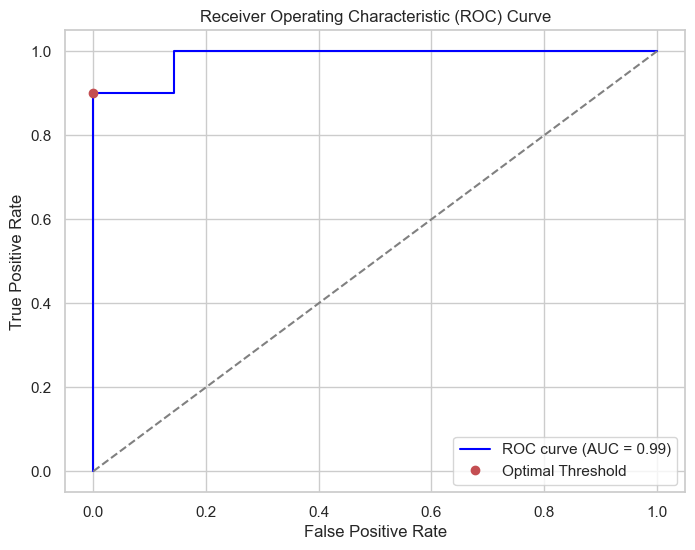

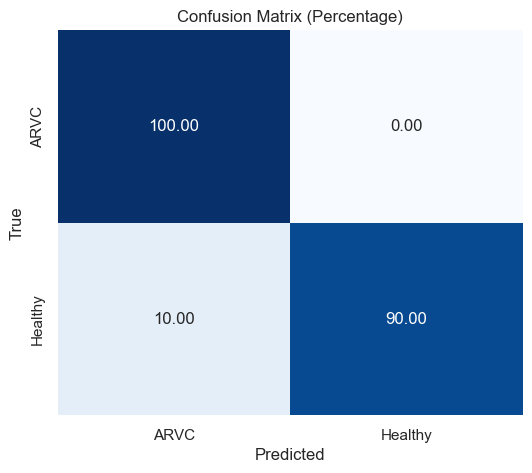

F1 Score: 0.95
Sensitivity: 0.90
Specificity: 1.00
Original data 1: 8 Original data 2: 11
Cleaned data 1: 7 Cleaned data 2: 10
Hypothesis: data1 < data2
T-statistic: -4.215589131531528
One-tailed p-value: 0.0010319403173648667
Two-tailed p-value: 0.0020638806347297333
The result is statistically significant (p-value = 0.0010)


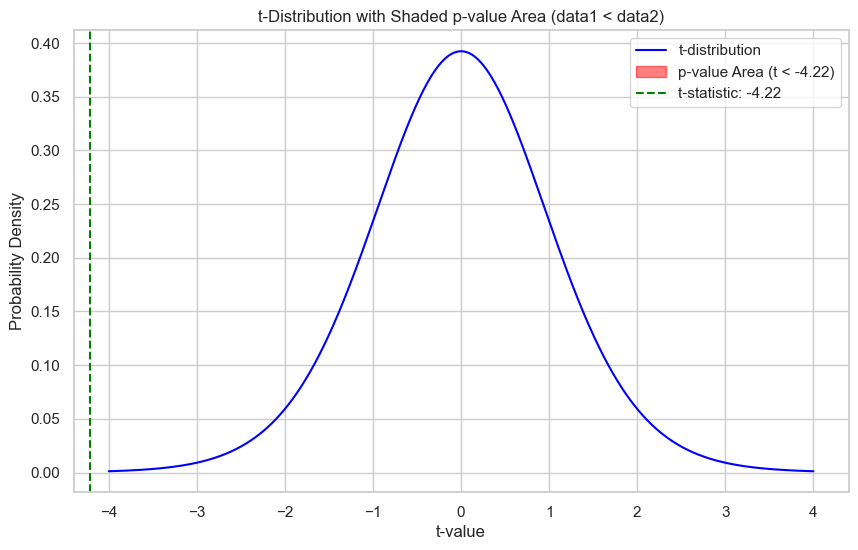

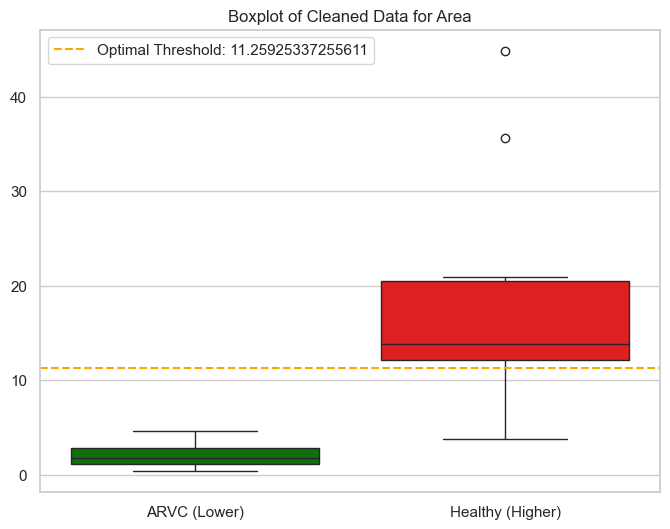

(-4.215589131531528, 0.0010319403173648667, True)

In [104]:
area_positive = positive_data_T["t_Area"].values
area_negative = negative_data_T["t_Area"].values

optimal_threshold, _, _, _ = determine_optimal_threshold(area_positive, area_negative, hypothesis="data2_greater", labels=("ARVC", "Healthy"), remove_outliers=True)


# Assuming the hypothesis is that the area of negative samples is greater than that of negative samples
perform_t_test(area_positive, area_negative, name="Area", hypothesis="data2_greater", threshold=optimal_threshold, labels=("ARVC", "Healthy"), remove_outliers=True )



## Analyze T segment Compact

data 1: 8 data 2: 10
Cleaned data 1: 8 Cleaned data 2: 10
Optimal Threshold: 0.9780257081843068
Maximum Youden Index: 0.4


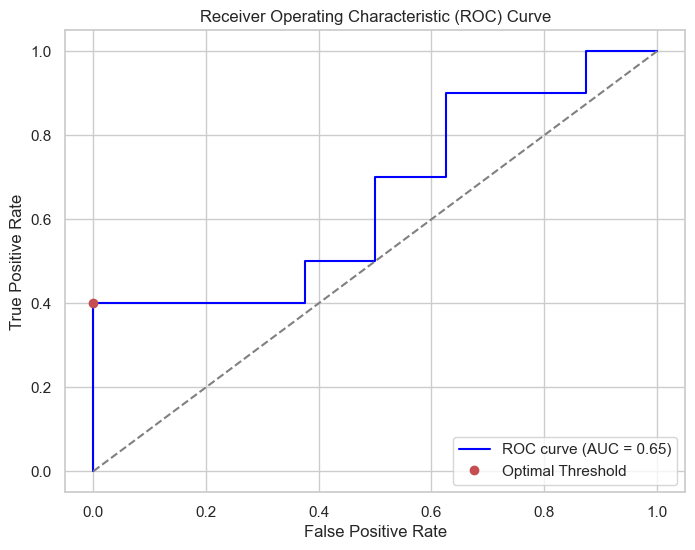

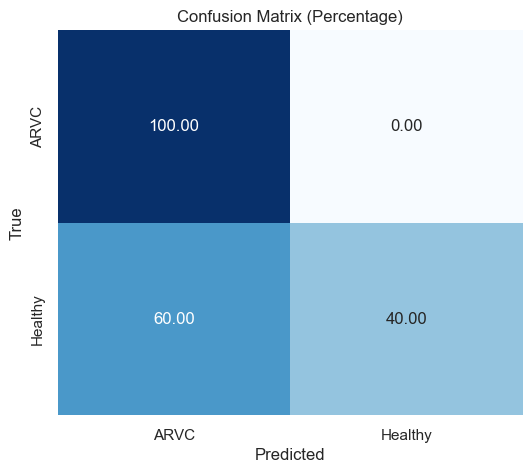

F1 Score: 0.57
Sensitivity: 0.40
Specificity: 1.00
Original data 1: 8 Original data 2: 10
Cleaned data 1: 8 Cleaned data 2: 10
Hypothesis: data1 < data2
T-statistic: -1.0976597786265787
One-tailed p-value: 0.1443817138810013
Two-tailed p-value: 0.2887634277620026
The result is not statistically significant (p-value = 0.1444)


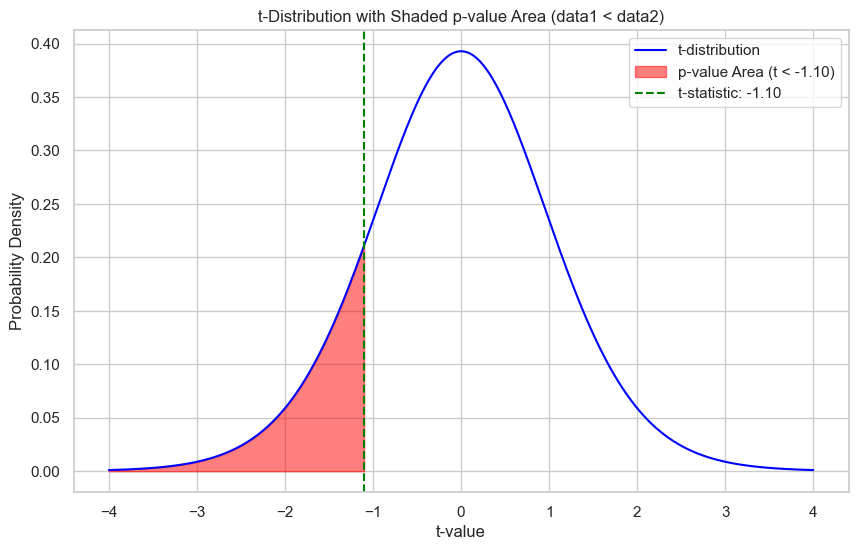

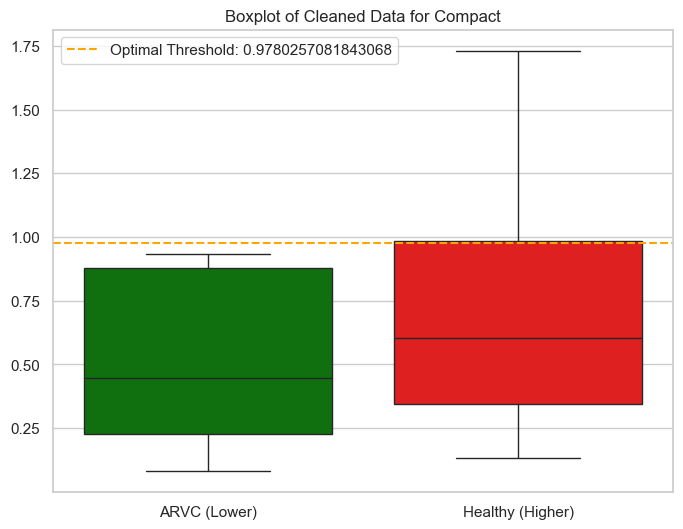

(-1.0976597786265787, 0.1443817138810013, False)

In [9]:
compact_positive = positive_data_T["t_Compact"].values
compact_negative = negative_data_T["t_Compact"].values

optimal_threshold, _, _, _ = determine_optimal_threshold(compact_positive, compact_negative, hypothesis="data2_greater", labels=("ARVC", "Healthy"))

# Assuming the hypothesis is that the area of negative samples is greater than that of negative samples
perform_t_test(compact_positive, compact_negative, name="Compact", hypothesis="data2_greater", labels=("ARVC", "Healthy"), threshold=optimal_threshold)



## T Segment T_Dist

data 1: 8 data 2: 10
Cleaned data 1: 8 Cleaned data 2: 10
Optimal Threshold: 13.69874548833072
Maximum Youden Index: 0.5


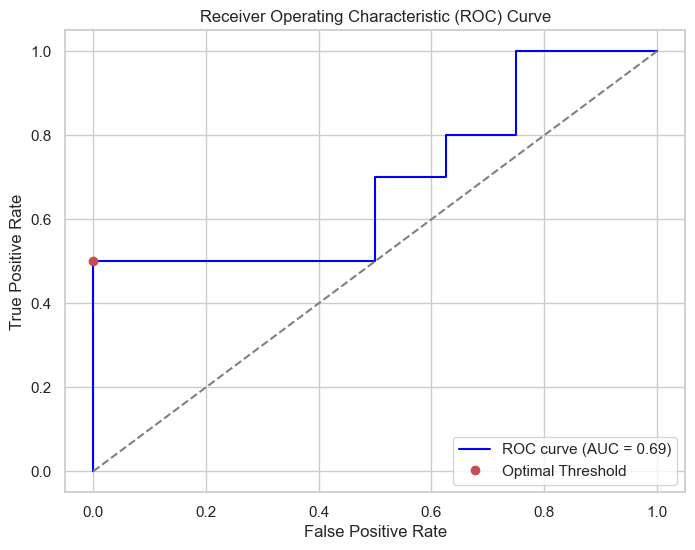

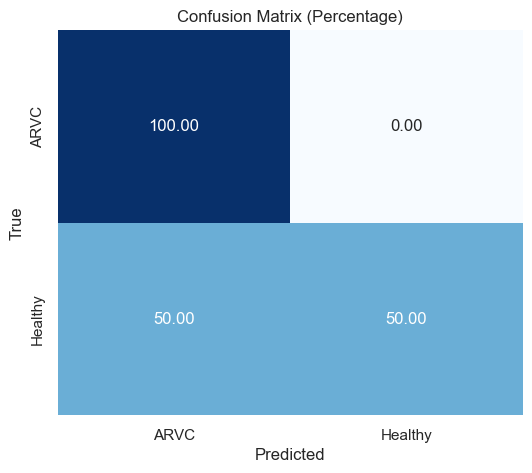

F1 Score: 0.67
Sensitivity: 0.50
Specificity: 1.00
Original data 1: 8 Original data 2: 10
Cleaned data 1: 8 Cleaned data 2: 10
Hypothesis: data1 < data2
T-statistic: -1.83134856032492
One-tailed p-value: 0.04286676790015416
Two-tailed p-value: 0.08573353580030832
The result is statistically significant (p-value = 0.0429)


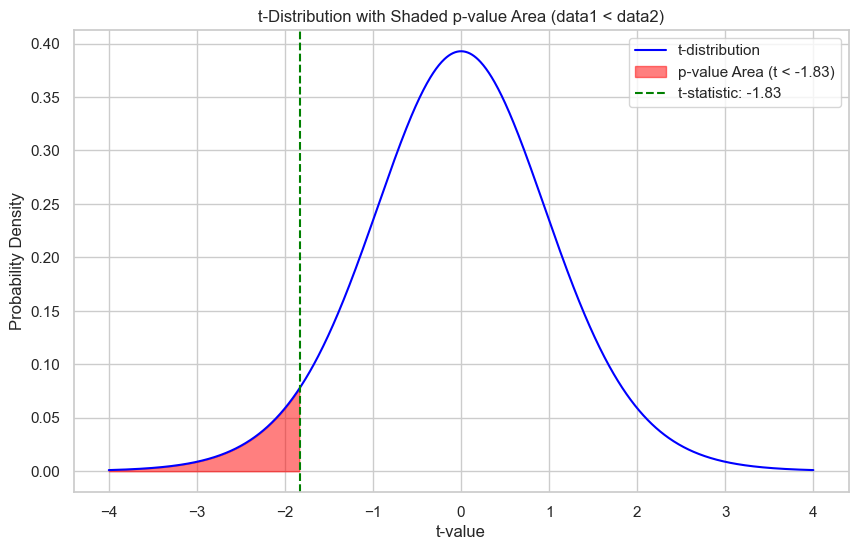

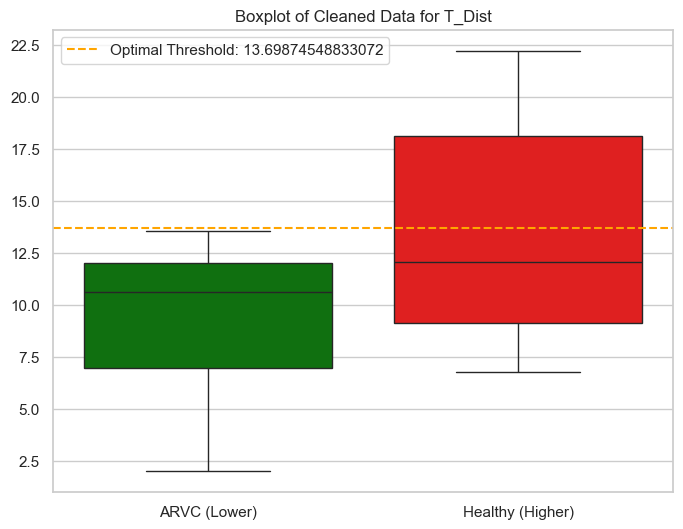

(-1.83134856032492, 0.04286676790015416, True)

In [10]:
t_dist_positive = positive_data_T["t_T-Dist"].values
t_dist_negative = negative_data_T["t_T-Dist"].values

optimal_threshold, _, _, _ = determine_optimal_threshold(t_dist_positive, t_dist_negative, hypothesis="data2_greater", labels=("ARVC", "Healthy"), remove_outliers=True)
    
# Assuming the hypothesis is that the area of negative samples is greater than that of negative samples
perform_t_test(t_dist_positive, t_dist_negative, name="T_Dist", hypothesis="data2_greater", labels=("ARVC", "Healthy"), threshold=optimal_threshold, remove_outliers=True)


## QRS Analysis Area

Area positive: [  0.12981363  10.9029475  101.02013583  65.43200519   6.53237416
   7.50964379   4.84959523   3.5203427 ]
Area negative: [ 61.14292687  59.75654183  15.96491566 295.09198197  24.38304916
   0.44483108 117.85867938  16.37235309 237.02224523  74.56968854
   2.92644946]
data 1: 8 data 2: 11
Cleaned data 1: 6 Cleaned data 2: 9
Optimal Threshold: 15.964915662100791
Maximum Youden Index: 0.7777777777777778


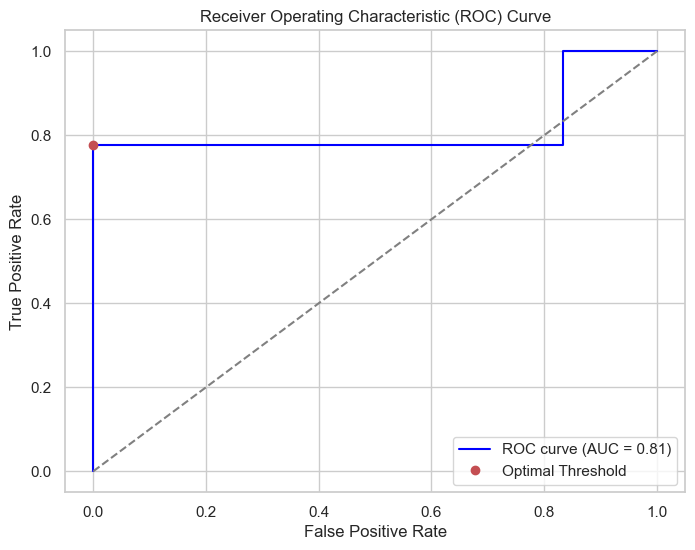

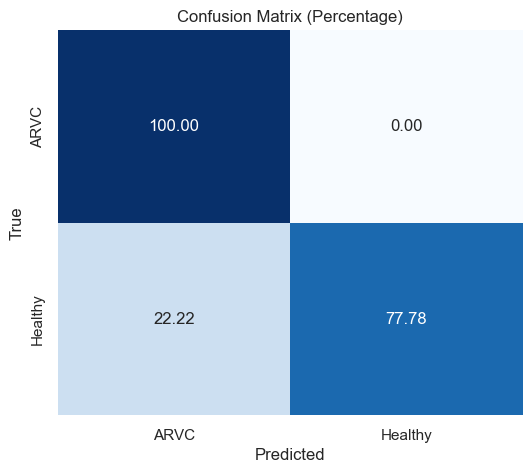

F1 Score: 0.88
Sensitivity: 0.78
Specificity: 1.00
Original data 1: 8 Original data 2: 11
Cleaned data 1: 6 Cleaned data 2: 9
Hypothesis: data1 < data2
T-statistic: -2.719910955834682
One-tailed p-value: 0.012821048986835039
Two-tailed p-value: 0.025642097973670078
The result is statistically significant (p-value = 0.0128)


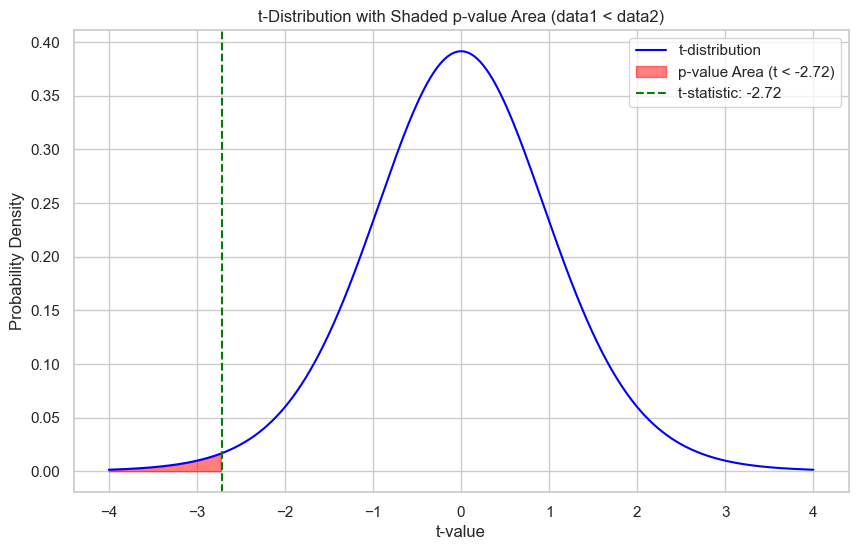

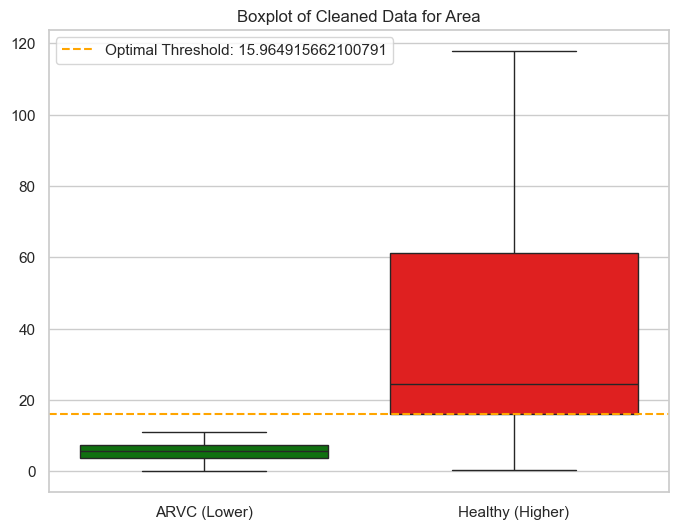

(-2.719910955834682, 0.012821048986835039, True)

In [105]:
area_positive = positive_data_QRS["qrs_Area"].values
area_negative = negative_data_QRS["qrs_Area"].values

print("Area positive:", area_positive)
print("Area negative:", area_negative)


optimal_threshold, _, _, _ = determine_optimal_threshold(area_positive, area_negative, hypothesis="data2_greater", labels=("ARVC", "Healthy"), remove_outliers=True)


# Assuming the hypothesis is that the area of negative samples is greater than that of negative samples
perform_t_test(area_positive, area_negative, name="Area", hypothesis="data2_greater", threshold=optimal_threshold, labels=("ARVC", "Healthy"), remove_outliers=True)



## QRS Analysis Compact

data 1: 6 data 2: 12
Cleaned data 1: 5 Cleaned data 2: 12
Optimal Threshold: 0.4829300413887194
Maximum Youden Index: 0.38333333333333336


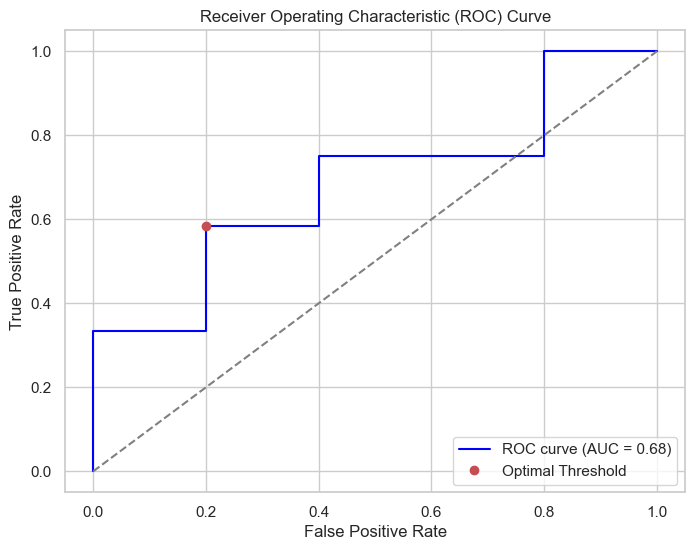

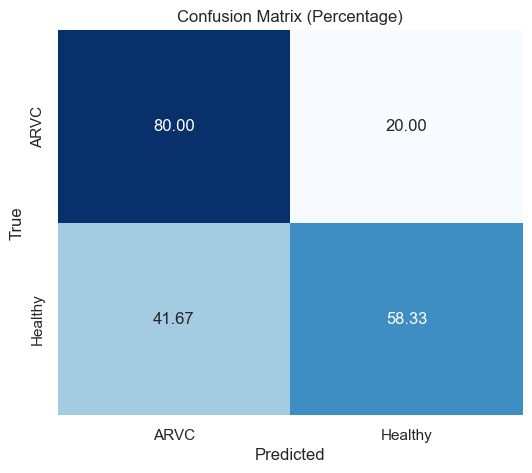

F1 Score: 0.70
Sensitivity: 0.58
Specificity: 0.80
Original data 1: 6 Original data 2: 12
Cleaned data 1: 5 Cleaned data 2: 12
Hypothesis: data1 < data2
T-statistic: -1.278233261486907
One-tailed p-value: 0.1162851179486949
Two-tailed p-value: 0.2325702358973898
The result is not statistically significant (p-value = 0.1163)


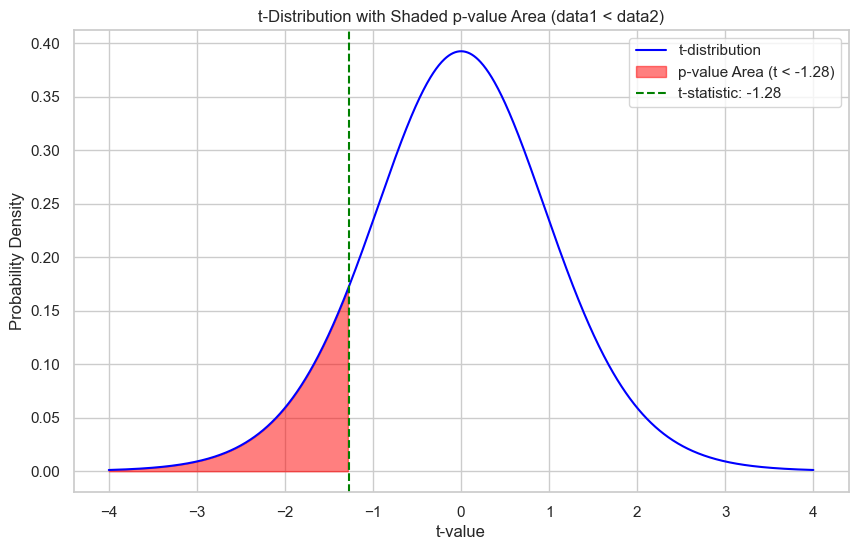

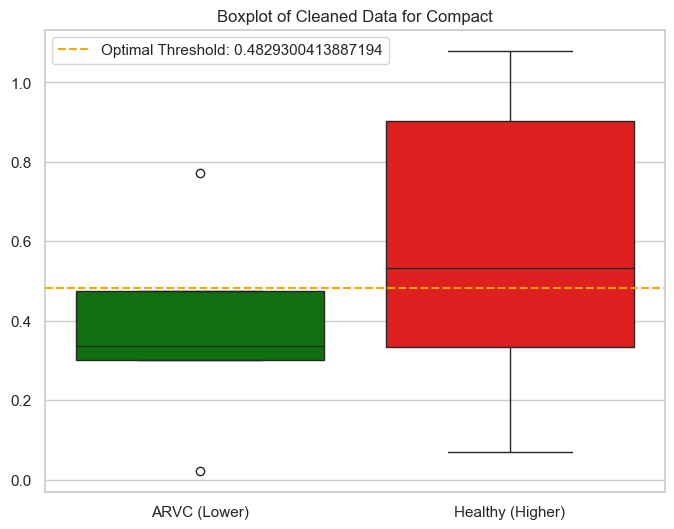

(-1.278233261486907, 0.1162851179486949, False)

In [36]:
compact_positive = positive_data_QRS["qrs_Compact"].values
compact_negative = negative_data_QRS["qrs_Compact"].values


optimal_threshold, _, _, _ = determine_optimal_threshold(compact_positive, compact_negative, hypothesis="data2_greater", labels=("ARVC", "Healthy"), remove_outliers=True)


# Assuming the hypothesis is that the area of negative samples is greater than that of negative samples
perform_t_test(compact_positive, compact_negative, name="Compact", hypothesis="data2_greater", labels=("ARVC", "Healthy"), threshold=optimal_threshold, remove_outliers=True)


## QRS T_Dist

data 1: 6 data 2: 12
Cleaned data 1: 6 Cleaned data 2: 12
Optimal Threshold: 11.53896746095165
Maximum Youden Index: 0.25


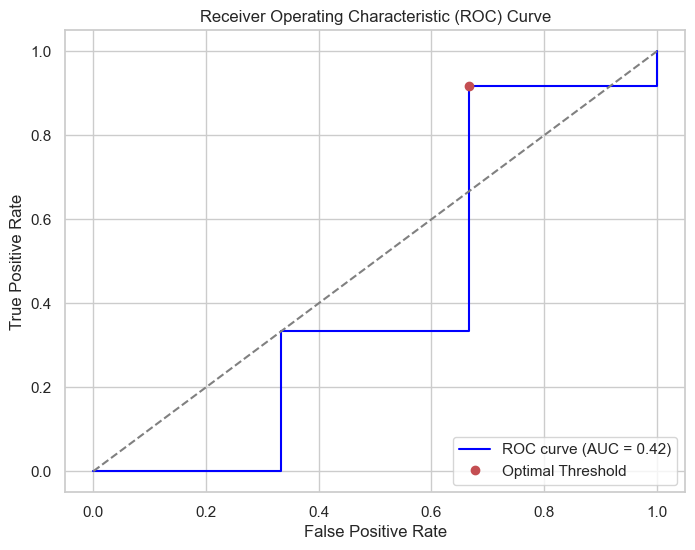

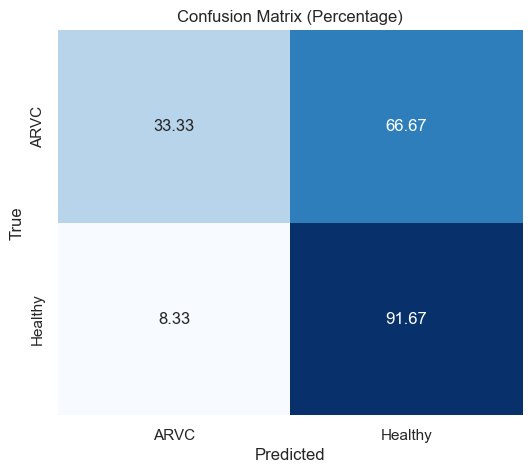

F1 Score: 0.81
Sensitivity: 0.92
Specificity: 0.33
Original data 1: 6 Original data 2: 12
Cleaned data 1: 6 Cleaned data 2: 12
Hypothesis: data1 < data2
T-statistic: 0.6266890726443729
One-tailed p-value: 0.7242692384688508
Two-tailed p-value: 0.5514615230622983
The result is not statistically significant (p-value = 0.7243)


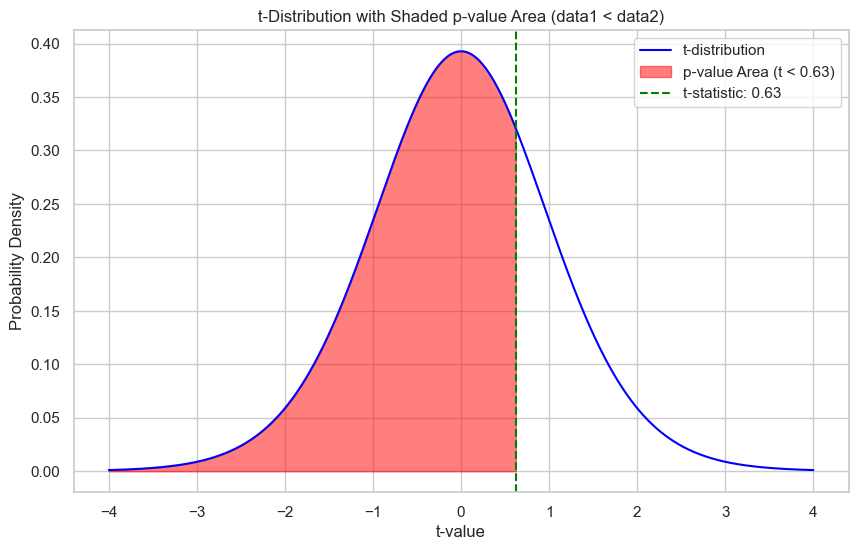

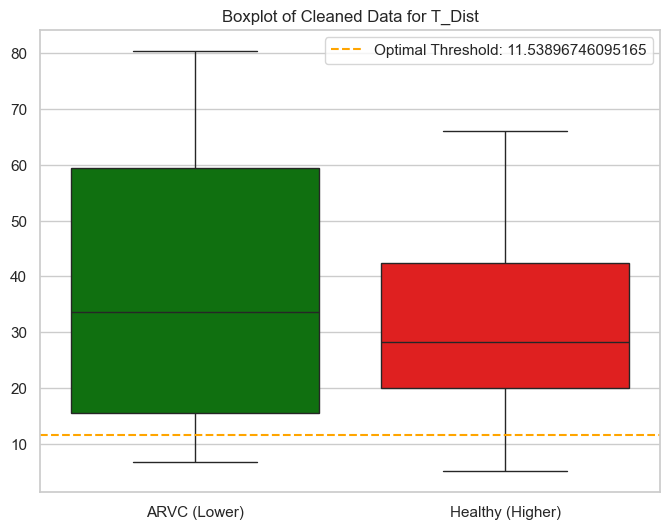

(0.6266890726443729, 0.7242692384688508, False)

In [37]:
t_dist_positive = positive_data_QRS["qrs_T-Dist"].values
t_dist_negative = negative_data_QRS["qrs_T-Dist"].values

optimal_threshold, _, _, _ = determine_optimal_threshold(t_dist_positive, t_dist_negative, hypothesis="data2_greater", labels=("ARVC", "Healthy"), remove_outliers=True)


# Assuming the hypothesis is that the area of negative samples is greater than that of negative samples
perform_t_test(t_dist_positive, t_dist_negative, name="T_Dist", hypothesis="data2_greater", labels=("ARVC", "Healthy"), threshold=optimal_threshold, remove_outliers=True)


## ST Area

data 1: 8 data 2: 11
Cleaned data 1: 6 Cleaned data 2: 9
Optimal Threshold: 5.901063586569706
Maximum Youden Index: 0.3333333333333333


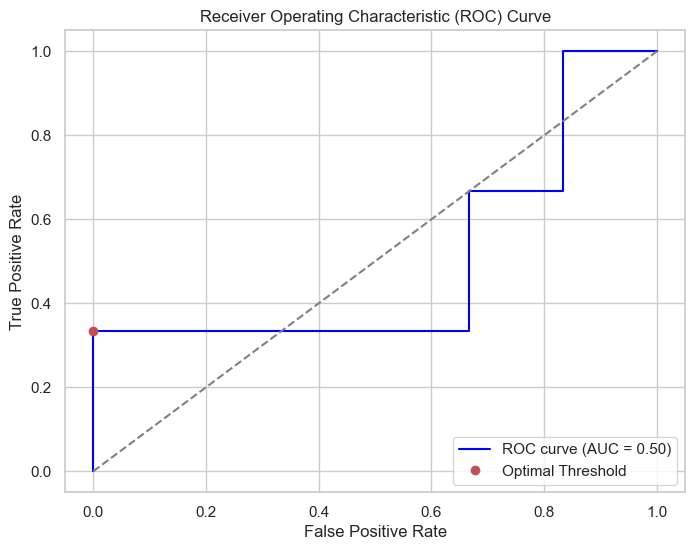

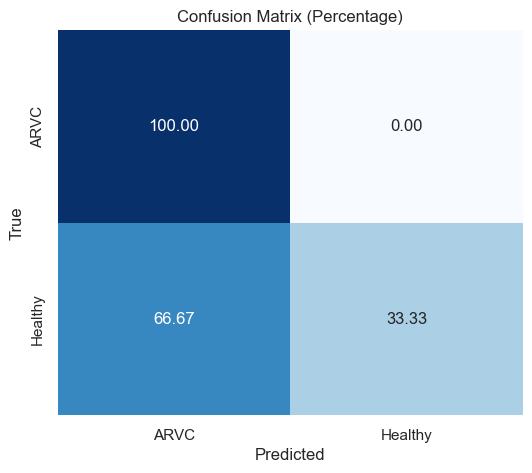

F1 Score: 0.50
Sensitivity: 0.33
Specificity: 1.00
Original data 1: 8 Original data 2: 11
Cleaned data 1: 6 Cleaned data 2: 9
Hypothesis: data1 < data2
T-statistic: -1.133062996249714
One-tailed p-value: 0.14429083368041098
Two-tailed p-value: 0.28858166736082197
The result is not statistically significant (p-value = 0.1443)


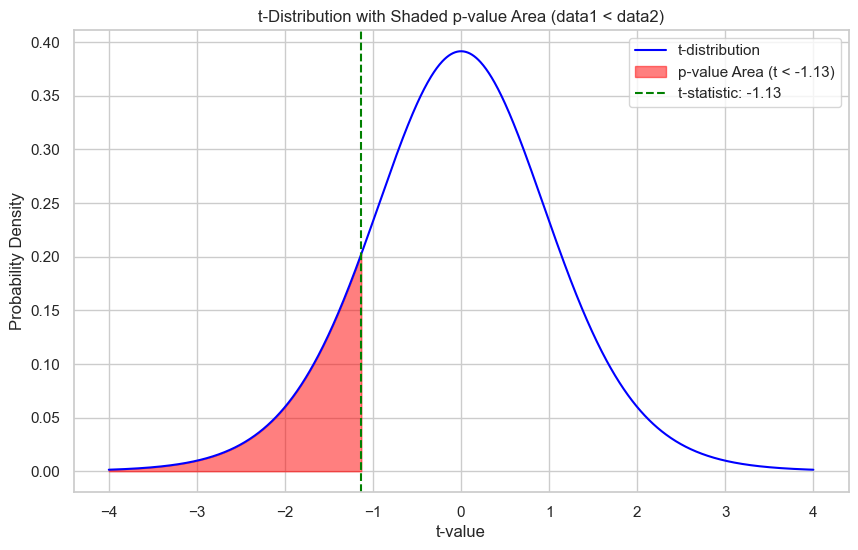

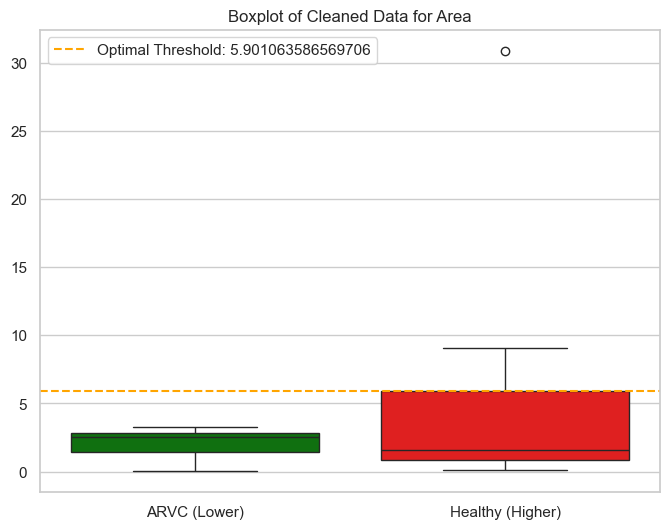

(-1.133062996249714, 0.14429083368041098, False)

In [106]:
area_positive = positive_data_ST["st_Area"].values
area_negative = negative_data_ST["st_Area"].values

optimal_threshold, _, _, _ = determine_optimal_threshold(area_positive, area_negative, hypothesis="data2_greater", labels=("ARVC", "Healthy"), remove_outliers=True)


# Assuming the hypothesis is that the area of negative samples is greater than that of negative samples
perform_t_test(area_positive, area_negative, name="Area", hypothesis="data2_greater", threshold=optimal_threshold, labels=("ARVC", "Healthy"), remove_outliers=True)



## ST Compact

data 1: 8 data 2: 10
Cleaned data 1: 8 Cleaned data 2: 8
Optimal Threshold: 0.1131552371893925
Maximum Youden Index: 0.25


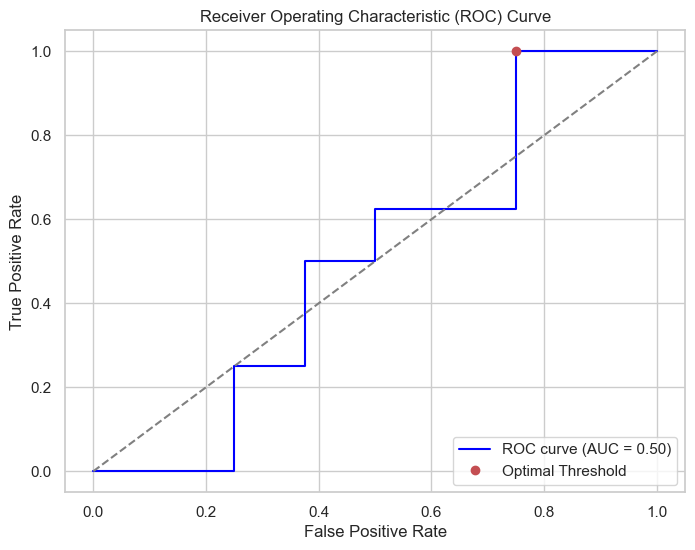

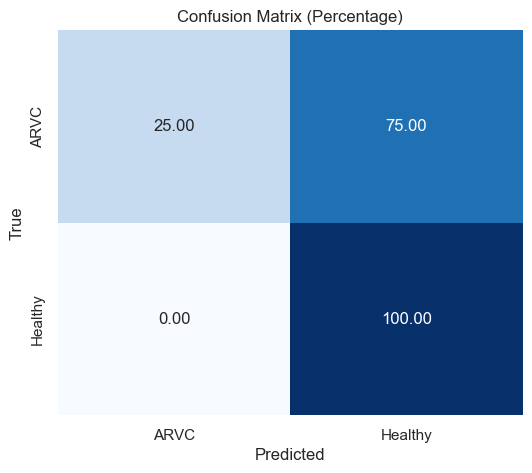

F1 Score: 0.73
Sensitivity: 1.00
Specificity: 0.25
Original data 1: 8 Original data 2: 10
Cleaned data 1: 8 Cleaned data 2: 8
Hypothesis: data1 < data2
T-statistic: 0.6361207263888639
One-tailed p-value: 0.7293009129117213
Two-tailed p-value: 0.5413981741765574
The result is not statistically significant (p-value = 0.7293)


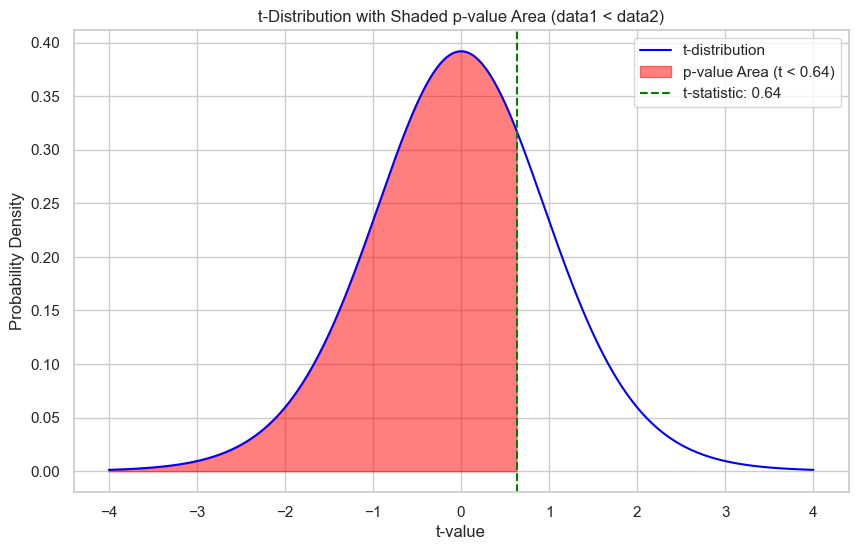

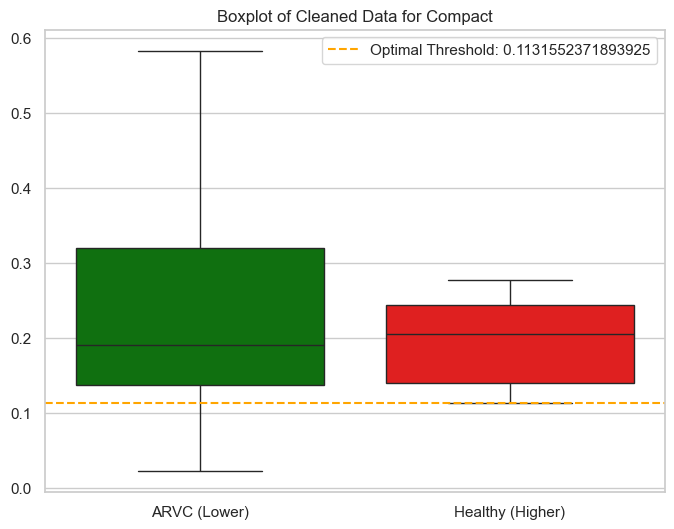

(0.6361207263888639, 0.7293009129117213, False)

In [10]:
compact_positive = positive_data_ST["st_Compact"].values
compact_negative = negative_data_ST["st_Compact"].values

optimal_threshold, _, _, _ = determine_optimal_threshold(compact_positive, compact_negative, hypothesis="data2_greater", labels=("ARVC", "Healthy"), remove_outliers=True)


# Assuming the hypothesis is that the area of negative samples is greater than that of negative samples
perform_t_test(compact_positive, compact_negative, name="Compact", hypothesis="data2_greater", threshold=optimal_threshold, labels=("ARVC", "Healthy"), remove_outliers=True)



## ST T-Dist

data 1: 8 data 2: 10
Cleaned data 1: 8 Cleaned data 2: 9
Optimal Threshold: 5.451635221470554
Maximum Youden Index: 0.16666666666666663


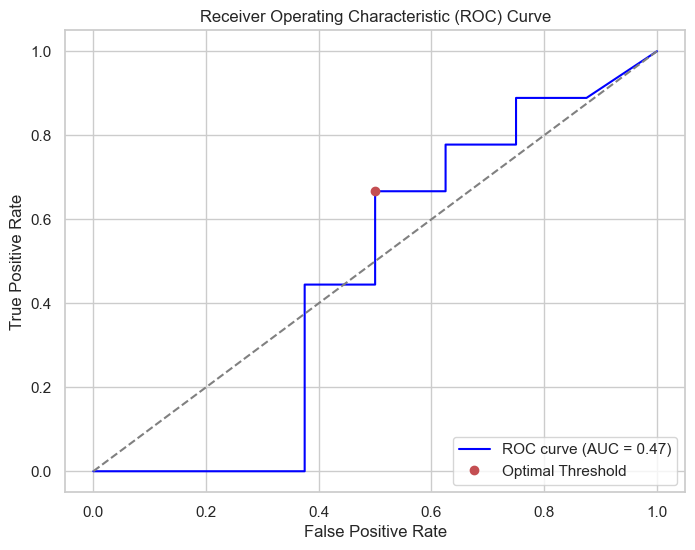

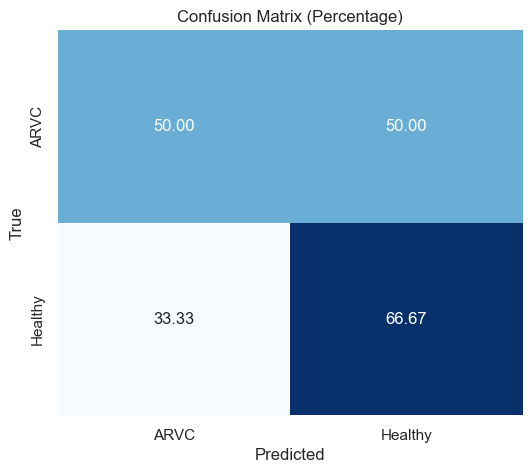

F1 Score: 0.63
Sensitivity: 0.67
Specificity: 0.50
Original data 1: 8 Original data 2: 10
Cleaned data 1: 6 Cleaned data 2: 10
Hypothesis: data1 < data2
T-statistic: -2.8841593533338967
One-tailed p-value: 0.009024037249586994
Two-tailed p-value: 0.018048074499173988
The result is statistically significant (p-value = 0.0090)


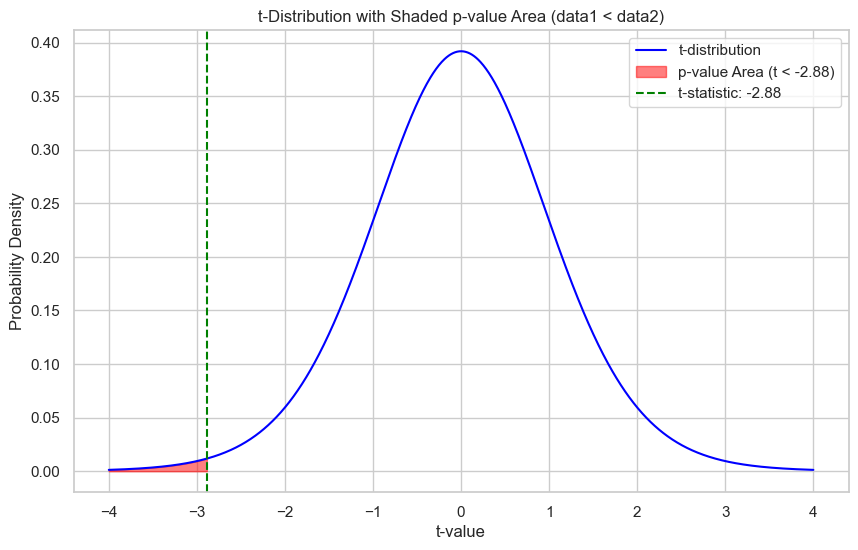

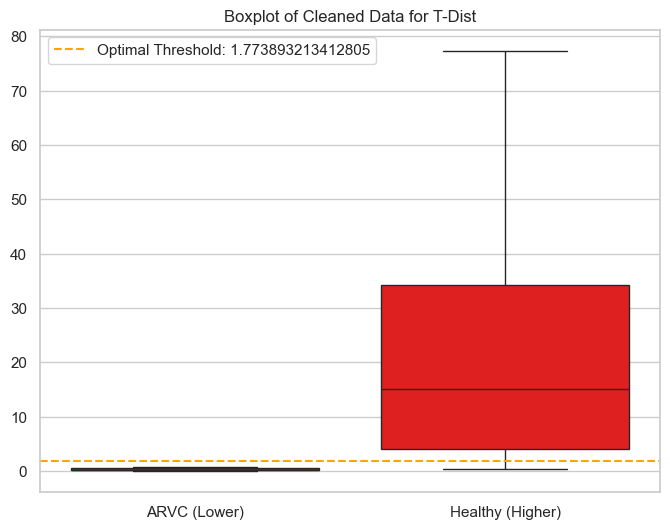

(-2.8841593533338967, 0.009024037249586994, True)

In [9]:
t_dist_positive = positive_data_ST["st_T-Dist"].values
t_dist_negative = negative_data_ST["st_T-Dist"].values

t_dis_threshold, _, _, _ = determine_optimal_threshold(t_dist_positive, t_dist_negative, hypothesis="data2_greater", labels=("ARVC", "Healthy"), remove_outliers=True)


# Assuming the hypothesis is that the area of negative samples is greater than that of negative samples
perform_t_test(area_positive, area_negative, name="T-Dist", hypothesis="data2_greater", threshold=optimal_threshold, labels=("ARVC", "Healthy"), remove_outliers=True)



## Analysis of all XY and YZ Projections

In [111]:
import glob
import os

# === Load JSON metadata ===
with open("Data/setup.json") as f:
    json_data = json.load(f)

# Build a dictionary: (patient, run) → ARVC label
arvc_map = {
    (pid, run_id): run_data["ARVC"]
    for pid, pdata in json_data.items()
    for run_id, run_data in pdata["runs"].items()
}

# === Helper to load and tag CSV files ===
def load_projection_data(projection):
    files = glob.glob(f"Results/*_{projection}.csv")
    dfs = []
    for file in files:
        df = pd.read_csv(file)
        df["ARVC"] = df.apply(lambda row: arvc_map.get((row["patient"], row["run"]), None), axis=1)
        df["source_file"] = os.path.basename(file)  # optional: for debugging
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# === Load and combine all xy and yz projection data ===
df_xy = load_projection_data("xy")
df_yz = load_projection_data("yz")

def prepare_segment_data(df, seg_cols):
    pos = df[df["ARVC"] == True][seg_cols].dropna(how="all")
    neg = df[df["ARVC"] == False][seg_cols].dropna(how="all")
    return pos, neg

# XY Projection
positive_data_T_xy, negative_data_T_xy = prepare_segment_data(df_xy, t_cols)
positive_data_QRS_xy, negative_data_QRS_xy = prepare_segment_data(df_xy, qrs_cols)
positive_data_ST_xy, negative_data_ST_xy = prepare_segment_data(df_xy, st_cols)

# YZ Projection
positive_data_T_yz, negative_data_T_yz = prepare_segment_data(df_yz, t_cols)
positive_data_QRS_yz, negative_data_QRS_yz = prepare_segment_data(df_yz, qrs_cols)
positive_data_ST_yz, negative_data_ST_yz = prepare_segment_data(df_yz, st_cols)




data 1: 61 data 2: 75
Cleaned data 1: 58 Cleaned data 2: 69
Optimal Threshold: 13.879066454517414
Maximum Youden Index: 0.60119940029985


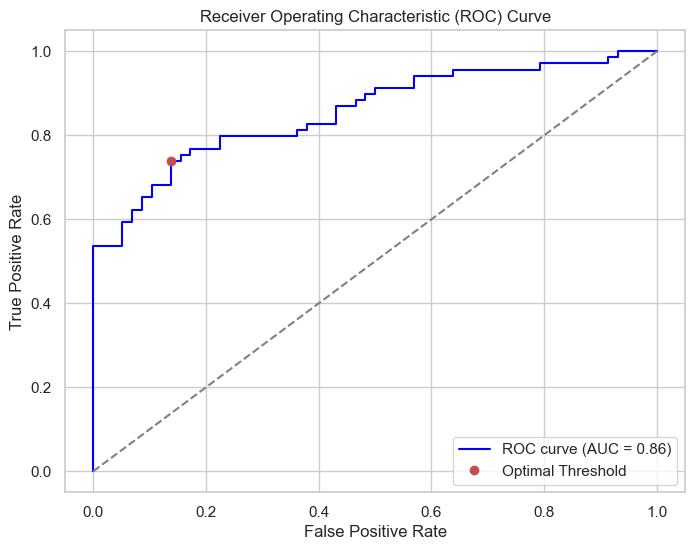

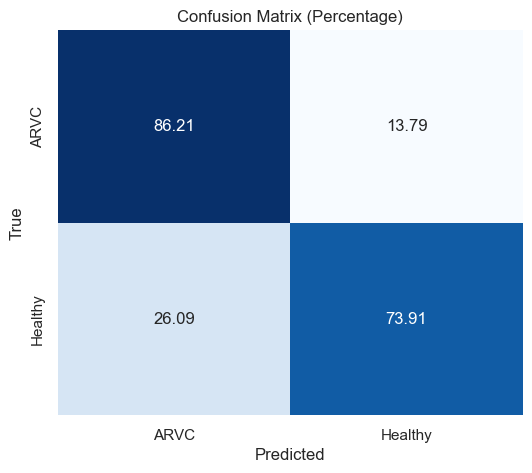

F1 Score: 0.80
Sensitivity: 0.74
Specificity: 0.86
Original data 1: 61 Original data 2: 75
Cleaned data 1: 58 Cleaned data 2: 69
Hypothesis: data1 < data2
T-statistic: -7.177151640210365
One-tailed p-value: 2.3068452758073193e-10
Two-tailed p-value: 4.6136905516146386e-10
The result is statistically significant (p-value = 0.0000)


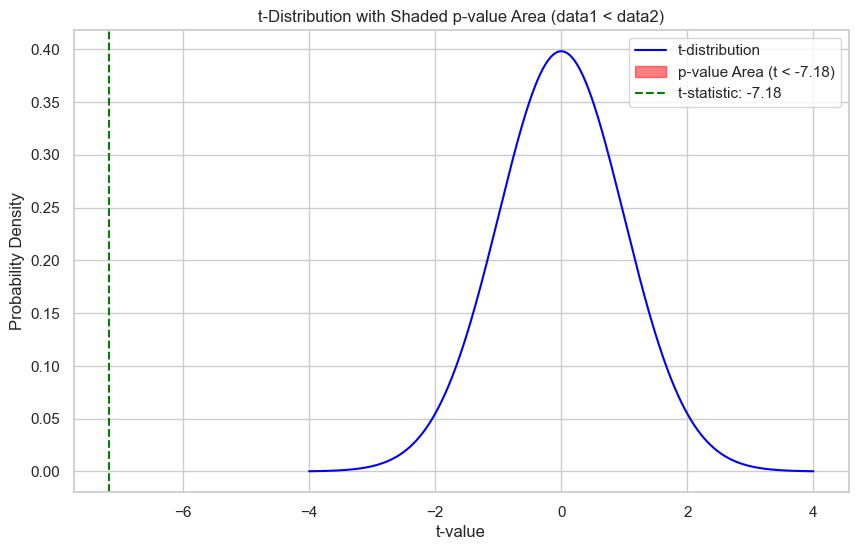

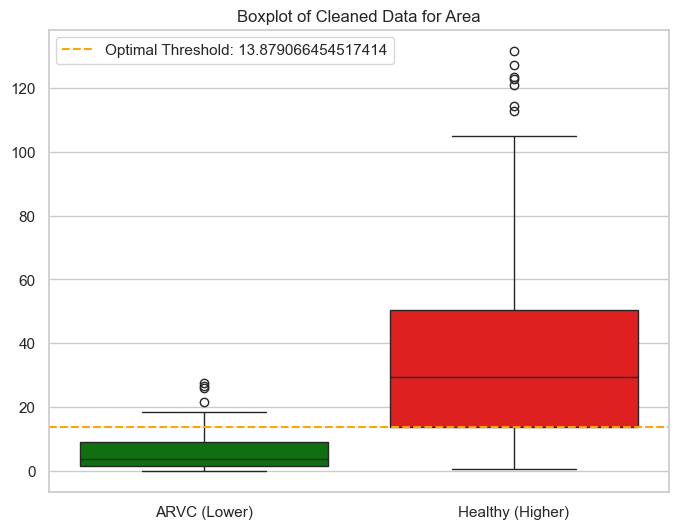

(-7.177151640210365, 2.3068452758073193e-10, True)

In [116]:
area_positive = positive_data_T_yz["t_Area"].values
area_negative = negative_data_T_yz["t_Area"].values

optimal_threshold, _, _, _ = determine_optimal_threshold(area_positive, area_negative, hypothesis="data2_greater", labels=("ARVC", "Healthy"), remove_outliers=True)


# Assuming the hypothesis is that the area of negative samples is greater than that of negative samples
perform_t_test(area_positive, area_negative, name="Area", hypothesis="data2_greater", threshold=optimal_threshold, labels=("ARVC", "Healthy"), remove_outliers=True )



data 1: 61 data 2: 75
Cleaned data 1: 52 Cleaned data 2: 71
Optimal Threshold: 104.43770373405788
Maximum Youden Index: 0.40574214517876483


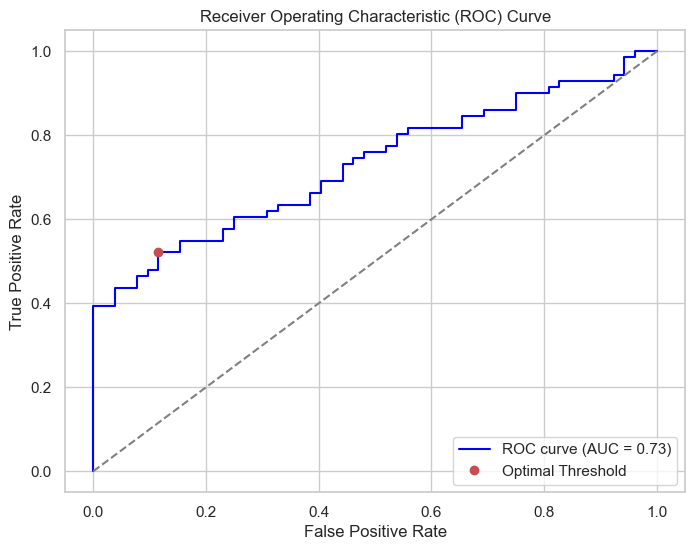

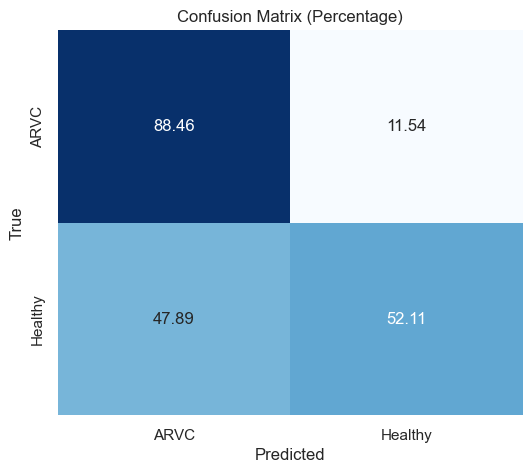

F1 Score: 0.65
Sensitivity: 0.52
Specificity: 0.88
Original data 1: 61 Original data 2: 75
Cleaned data 1: 52 Cleaned data 2: 71
Hypothesis: data1 < data2
T-statistic: -5.813052673076255
One-tailed p-value: 5.687909064576955e-08
Two-tailed p-value: 1.137581812915391e-07
The result is statistically significant (p-value = 0.0000)


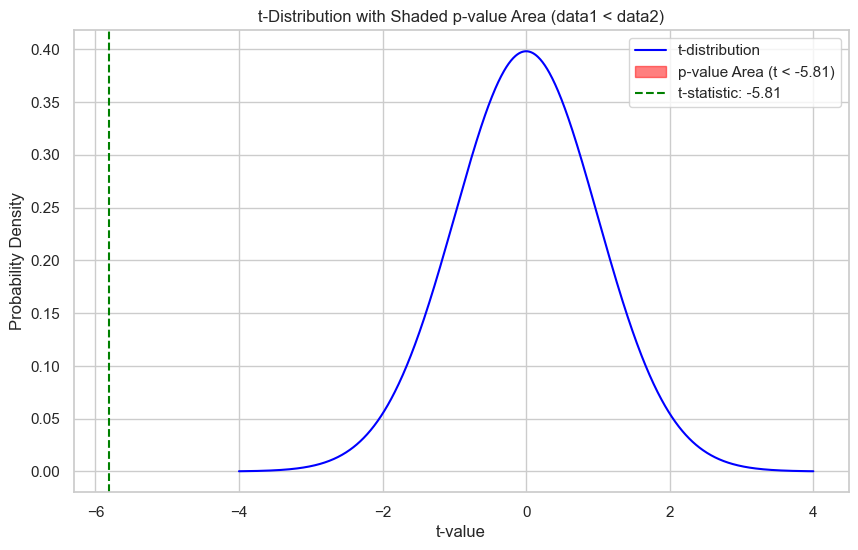

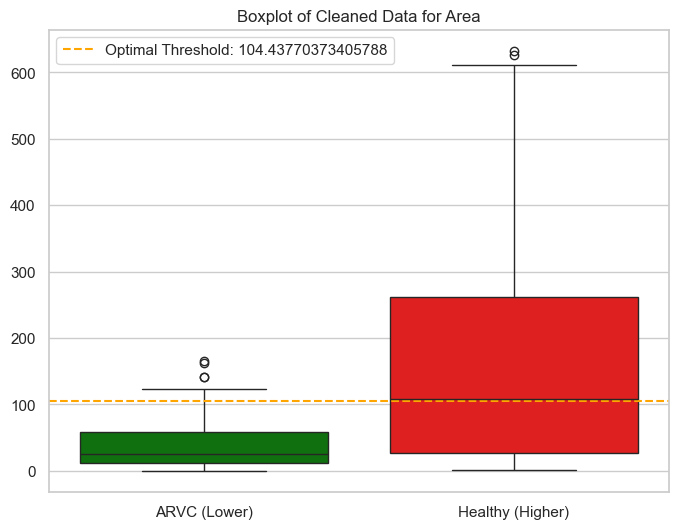

(-5.813052673076255, 5.687909064576955e-08, True)

In [117]:
area_positive = positive_data_QRS_yz["qrs_Area"].values
area_negative = negative_data_QRS_yz["qrs_Area"].values

optimal_threshold, _, _, _ = determine_optimal_threshold(area_positive, area_negative, hypothesis="data2_greater", labels=("ARVC", "Healthy"), remove_outliers=True)


# Assuming the hypothesis is that the area of negative samples is greater than that of negative samples
perform_t_test(area_positive, area_negative, name="Area", hypothesis="data2_greater", threshold=optimal_threshold, labels=("ARVC", "Healthy"), remove_outliers=True )



data 1: 61 data 2: 75
Cleaned data 1: 50 Cleaned data 2: 66
Optimal Threshold: 6.500921620916069
Maximum Youden Index: 0.3551515151515151


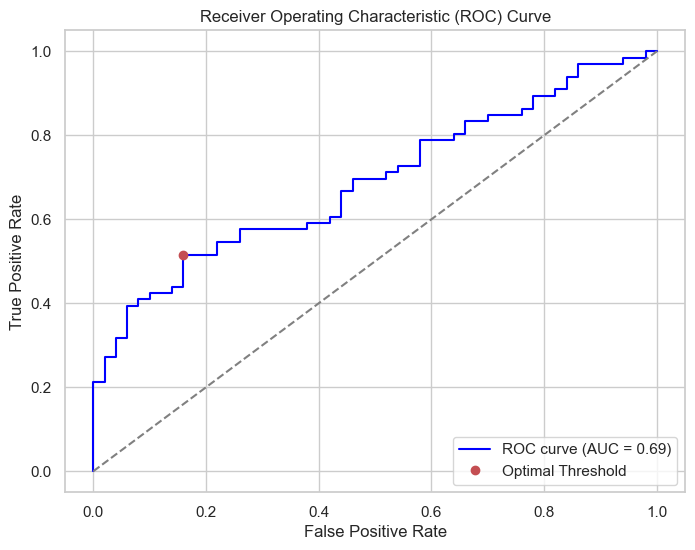

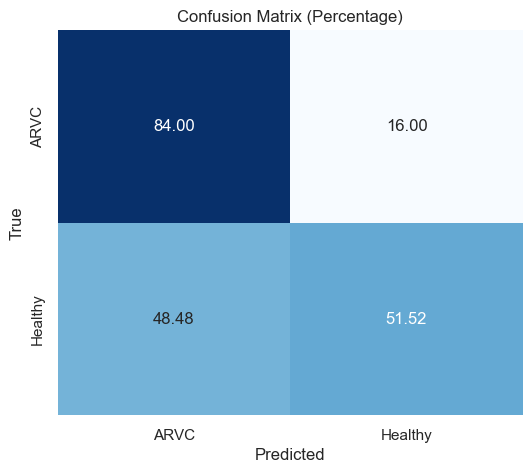

F1 Score: 0.63
Sensitivity: 0.52
Specificity: 0.84
Original data 1: 61 Original data 2: 75
Cleaned data 1: 50 Cleaned data 2: 66
Hypothesis: data1 < data2
T-statistic: -4.506421677361892
One-tailed p-value: 1.0921176111584713e-05
Two-tailed p-value: 2.1842352223169426e-05
The result is statistically significant (p-value = 0.0000)


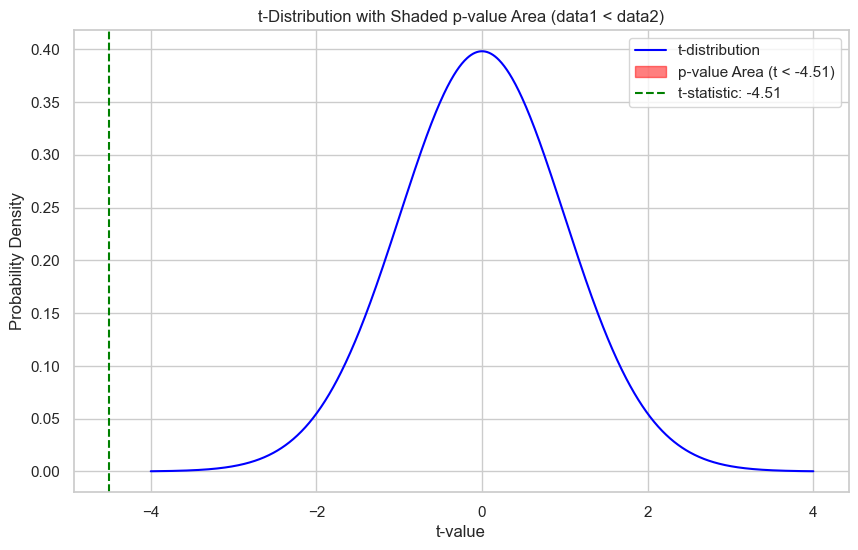

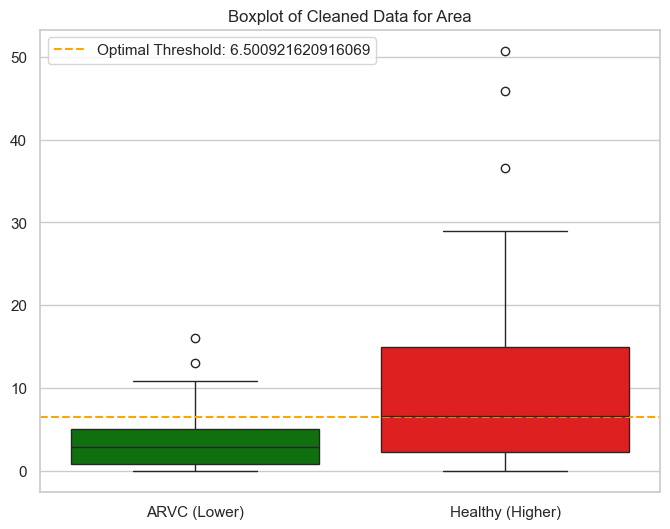

(-4.506421677361892, 1.0921176111584713e-05, True)

In [118]:
area_positive = positive_data_ST_yz["st_Area"].values
area_negative = negative_data_ST_yz["st_Area"].values

optimal_threshold, _, _, _ = determine_optimal_threshold(area_positive, area_negative, hypothesis="data2_greater", labels=("ARVC", "Healthy"), remove_outliers=True)


# Assuming the hypothesis is that the area of negative samples is greater than that of negative samples
perform_t_test(area_positive, area_negative, name="Area", hypothesis="data2_greater", threshold=optimal_threshold, labels=("ARVC", "Healthy"), remove_outliers=True )

